## Introduction to Image Filtering



In [188]:
using Images, ImageFeatures, TestImages, BenchmarkTools

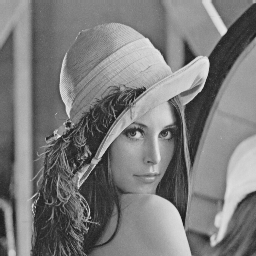

In [189]:
img = testimage("lena_gray")

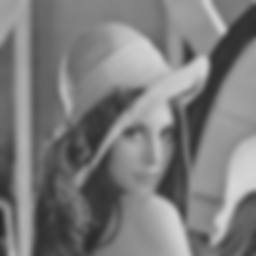

In [190]:
imgg = imfilter(img, Kernel.gaussian(3))

### OffsetArrays


In [106]:
#?ImageFiltering.OffsetArrays.OffsetArray

In [93]:
typeof(centered([1 0 0]))

OffsetArrays.OffsetArray{Int64,2,Array{Int64,2}}

### Computing correlations with `imfilter` 

We will see in particular how to compute the gradient of an image.

In [35]:
[-1 0 1] 

1×3 Array{Int64,2}:
 -1  0  1

In [39]:
[-1 0 1]'

3×1 LinearAlgebra.Adjoint{Int64,Array{Int64,2}}:
 -1
  0
  1

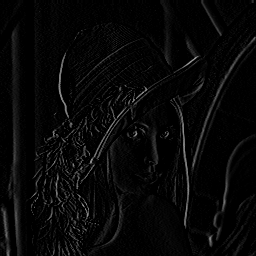

In [52]:
# Notice [-1 0 1] has 1 row and 3 columns. This is applied at every position of the image
# and will magnify vertical edges,like the nose
imfilter(img, [-1 0 1])

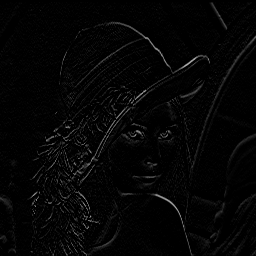

In [59]:
imfilter(img, [-1 0 1]')

In [116]:
@benchmark imfilter(img, [-1 0 1])

BenchmarkTools.Trial: 
  memory estimate:  1.82 MiB
  allocs estimate:  245
  --------------
  minimum time:     1.392 ms (0.00% GC)
  median time:      1.861 ms (0.00% GC)
  mean time:        2.011 ms (8.11% GC)
  maximum time:     7.302 ms (62.82% GC)
  --------------
  samples:          2477
  evals/sample:     1

In [55]:
@benchmark imfilter(img, [-1 0 1]')

BenchmarkTools.Trial: 
  memory estimate:  612.31 KiB
  allocs estimate:  1005
  --------------
  minimum time:     1.536 ms (0.00% GC)
  median time:      1.853 ms (0.00% GC)
  mean time:        1.916 ms (4.39% GC)
  maximum time:     5.792 ms (71.26% GC)
  --------------
  samples:          2604
  evals/sample:     1

#### Rewriting  [-1 0 1] as ResphaedOneD

We can make `imfulter` musch faster using

```
kernel_x = (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),)
```

In [121]:
?ImageFiltering.ReshapedOneD{2,1}

```
ReshapedOneD{N,Npre}(data)
```

Return an object of dimensionality `N`, where `data` must have dimensionality 1. The axes are `0:0` for the first `Npre` dimensions, have the axes of `data` for dimension `Npre+1`, and are `0:0` for the remaining dimensions.

`data` must support `eltype` and `ndims`, but does not have to be an AbstractArray.

ReshapedOneDs allow one to specify a "filtering dimension" for a 1-dimensional filter.


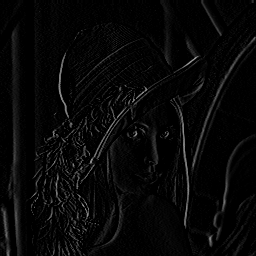

In [128]:
kernel_x = (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),)
imfilter(img, kernel_x)

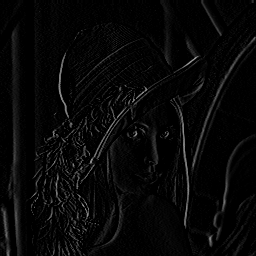

In [227]:
imfilter(img, [-1 0 1])

In [233]:
0.001347 * 60

0.08082

In [130]:
@btime imfilter(img, kernel_x);

  211.356 μs (23 allocations: 519.23 KiB)


In [83]:
@btime imfilter(img, [-1 0 1]);

  1.347 ms (241 allocations: 1.82 MiB)


In [208]:
@benchmark imfilter($img, $kernel_x)

BenchmarkTools.Trial: 
  memory estimate:  519.23 KiB
  allocs estimate:  23
  --------------
  minimum time:     216.637 μs (0.00% GC)
  median time:      483.197 μs (0.00% GC)
  mean time:        522.177 μs (12.87% GC)
  maximum time:     4.850 ms (87.39% GC)
  --------------
  samples:          9520
  evals/sample:     1

#### The same in the y dimension

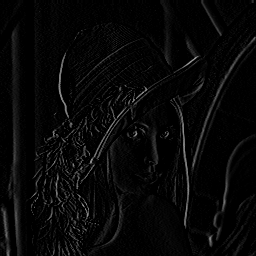

In [199]:
## works
k2 = (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),)
imfilter(img, k2)

In [201]:
## does not work
k2 = ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1]))
#imfilter(img, k2)

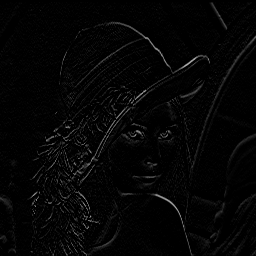

In [225]:
kernel = (ImageFiltering.ReshapedOneD{2,0}(centered([-1,0,1])),)
imfilter(img, kernel)

In [226]:
@benchmark imfilter($img, $kernel)

BenchmarkTools.Trial: 
  memory estimate:  519.23 KiB
  allocs estimate:  23
  --------------
  minimum time:     221.203 μs (0.00% GC)
  median time:      487.077 μs (0.00% GC)
  mean time:        527.690 μs (13.03% GC)
  maximum time:     7.241 ms (91.25% GC)
  --------------
  samples:          9418
  evals/sample:     1

In [223]:
@benchmark imfilter($img, $kernel)

BenchmarkTools.Trial: 
  memory estimate:  520.23 KiB
  allocs estimate:  23
  --------------
  minimum time:     221.690 μs (0.00% GC)
  median time:      482.206 μs (0.00% GC)
  mean time:        518.914 μs (13.21% GC)
  maximum time:     6.629 ms (92.20% GC)
  --------------
  samples:          9582
  evals/sample:     1

#### Be careful with the dimension of the kernel

In [56]:
k1 = [-1,0,1]

3-element Array{Int64,1}:
 -1
  0
  1

In [57]:
k2 = [-1;0;1]

3-element Array{Int64,1}:
 -1
  0
  1

In [58]:
k1_2 = reshape([-1,0,1],(3,1))

3×1 Array{Int64,2}:
 -1
  0
  1

In [47]:
[-1,0,1]

3-element Array{Int64,1}:
 -1
  0
  1

### Using `imfilter!` inplace

In some situations it is relevant to avoid garabage collection. Notice that the benchmark of `imfilter(image, kernel)` shows a maximum time of 4.4 ms which is about 10 times more time than the median time.

```
  minimum time:     220.840 μs (0.00% GC)
  median time:      480.618 μs (0.00% GC)
  mean time:        512.881 μs (12.22% GC)
  maximum time:     4.421 ms (89.75% GC)
```

To avoid this issue we can use `imfilter!(out_image, image, kernel)` which allows us to write on `out_image` the output of the function without (in theory) allocating memory. 

In [212]:
?ImageFiltering.ReshapedOneD

```
ReshapedOneD{N,Npre}(data)
```

Return an object of dimensionality `N`, where `data` must have dimensionality 1. The axes are `0:0` for the first `Npre` dimensions, have the axes of `data` for dimension `Npre+1`, and are `0:0` for the remaining dimensions.

`data` must support `eltype` and `ndims`, but does not have to be an AbstractArray.

ReshapedOneDs allow one to specify a "filtering dimension" for a 1-dimensional filter.
